# Assignment 1 - Music Genre Classification
## FYS-2021: Machine Learning with Logistic Regression
In this notebook, we will develop a logistic regression model to classify music tracks into two genres: Pop and Classical. The features used are 'liveness' and 'loudness'.

### Step 1: Import Required Libraries and Define Custom Scaler
We'll start by importing the necessary libraries and creating a custom implementation of the standard scaler, which is used to normalize the features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(30)  # Set seed for reproducibility

# Custom Standard Scaler (a simplified version)
class CustomStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)

    def transform(self, X):
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


### Step 2: Load and Inspect the Dataset
We will now load the dataset and inspect its structure to understand what we are working with.

In [2]:
# Load the dataset
data = pd.read_csv('../data/SpotifyFeatures.csv')
print(f'Number of samples: {data.shape[0]}')
print(f'Number of features: {data.shape[1]}')

Number of samples: 232725
Number of features: 18


### Step 3: Filter the Data for Pop and Classical Genres
Next, we will filter the dataset to only include songs from the 'Pop' and 'Classical' genres, and create labels for the two genres.

In [3]:
# Filter dataset for Pop and Classical genres
pop_class_df = data[data['genre'].isin(['Pop', 'Classical'])].copy()

# Create labels: 'Pop' = 1, 'Classical' = 0
pop_class_df['label'] = pop_class_df['genre'].apply(lambda x: 1 if x == 'Pop' else 0)

# Report number of samples in each genre
num_pop = pop_class_df[pop_class_df['label'] == 1].shape[0]
num_classical = pop_class_df[pop_class_df['label'] == 0].shape[0]
print(f'Number of Pop songs: {num_pop}')
print(f'Number of Classical songs: {num_classical}')

Number of Pop songs: 9386
Number of Classical songs: 9256


### Step 4: Feature Extraction
We will now extract the relevant features ('liveness' and 'loudness') and the labels from the dataset. These will be used for training and testing.

In [4]:
# Extract features ('liveness' and 'loudness')
features = pop_class_df[['liveness', 'loudness']].values
labels = pop_class_df['label'].values

# Display feature ranges
print(f'Liveness range: {features[:, 0].min()} to {features[:, 0].max()}')
print(f'Loudness range: {features[:, 1].min()} to {features[:, 1].max()}')

Liveness range: 0.0157 to 0.987
Loudness range: -47.599 to 0.634


### Step 5: Split Data into Training and Test Sets
We will split the data into training (80%) and test (20%) sets, while maintaining class distribution.

In [5]:
# Split data into training and test sets (80% train, 20% test)
train_ratio = 0.8
np.random.seed(30)
indices = np.random.permutation(len(features))
train_size = int(train_ratio * len(features))

# Split the features and labels
X_train = features[indices[:train_size]]
y_train = labels[indices[:train_size]]
X_test = features[indices[train_size:]]
y_test = labels[indices[train_size:]]

print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 14913
Test set size: 3729


### Step 6: Standardize the Data
To ensure that all features are on the same scale, we'll standardize the features using our custom scaler.

In [6]:
# Standardize the data
scaler = CustomStandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Step 7: Visualize the Data
Let's visualize the data in terms of liveness and loudness, and see if there's any clear separation between the two genres.

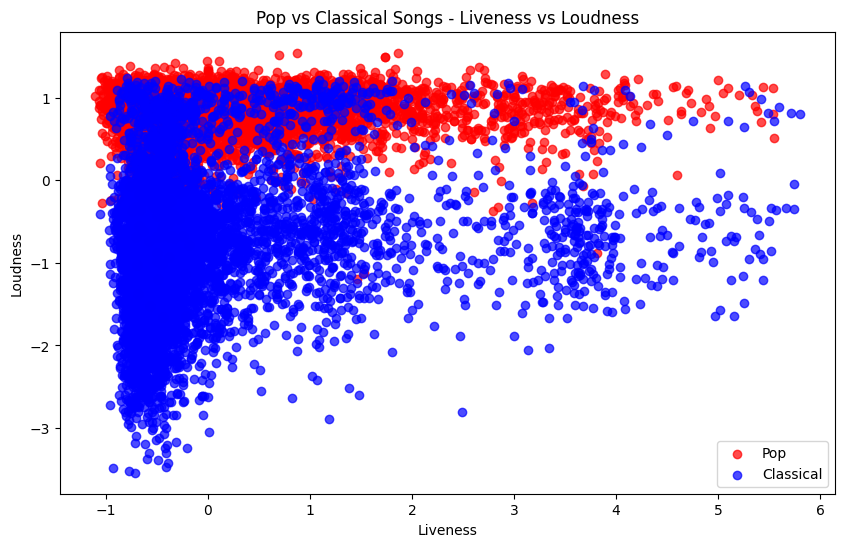

In [7]:
# Plot the features for Pop and Classical songs
plt.figure(figsize=(10, 6))
plt.scatter(X_train_scaled[y_train == 1][:, 0], X_train_scaled[y_train == 1][:, 1], color='red', label='Pop', alpha=0.7)
plt.scatter(X_train_scaled[y_train == 0][:, 0], X_train_scaled[y_train == 0][:, 1], color='blue', label='Classical', alpha=0.7)
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.legend()
plt.title('Pop vs Classical Songs - Liveness vs Loudness')
plt.show()

### Step 8: Logistic Regression with Stochastic Gradient Descent
We will now implement logistic regression using Stochastic Gradient Descent (SGD) and evaluate its performance.

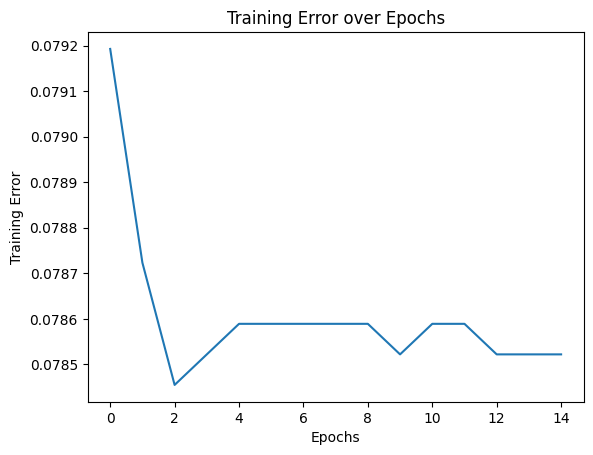

In [8]:
# Logistic regression using SGD
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_sgd(X, y, learning_rate, epochs):
    weights = np.random.randn(X.shape[1])
    errors = []
    for epoch in range(epochs):
        for i in range(X.shape[0]):
            z = X[i] @ weights
            h = sigmoid(z)
            gradient = (h - y[i]) * X[i]
            weights -= learning_rate * gradient
        y_pred = (sigmoid(X @ weights) >= 0.5).astype(int)
        errors.append(np.mean(y_pred != y))
    return weights, errors

# Train the model
learning_rate = 0.0001
epochs = 15
weights, errors = logistic_sgd(X_train_scaled, y_train, learning_rate, epochs)

# Plot the training error
plt.plot(range(epochs), errors)
plt.xlabel('Epochs')
plt.ylabel('Training Error')
plt.title('Training Error over Epochs')
plt.show()

### Step 9: Evaluate Model Performance
We will now evaluate the model's performance on both the training and test sets by calculating the accuracy and confusion matrix.

In [9]:
# Evaluate model accuracy
def predict(X, weights):
    return (sigmoid(X @ weights) >= 0.5).astype(int)

# Training accuracy
y_train_pred = predict(X_train_scaled, weights)
train_accuracy = np.mean(y_train_pred == y_train)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Test accuracy
y_test_pred = predict(X_test_scaled, weights)
test_accuracy = np.mean(y_test_pred == y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Training Accuracy: 92.15%
Test Accuracy: 91.66%


### Step 10: Confusion Matrix and Performance Metrics
We will now calculate the confusion matrix, sensitivity, specificity, and precision to better understand how the model performs.

In [10]:
# Confusion Matrix Calculation
def confusion_matrix(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[TP, FP], [FN, TN]])

# Calculate confusion matrix for test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Extract values
TP, FP = conf_matrix[0]
FN, TN = conf_matrix[1]


# Calculate performance metrics
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
f1_score = 2 * TP / (2 * TP + FP + FN)

print(f'Sensitivity (Recall): {sensitivity * 100:.2f}%')
print(f'Specificity: {specificity * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'F1-score: {f1_score * 100:.2f}%')

Confusion Matrix:
[[1877  284]
 [  27 1541]]
Sensitivity (Recall): 98.58%
Specificity: 84.44%
Precision: 86.86%
Accuracy: 91.66%
F1-score: 92.35%


### Step 11: Song Recommendations
Let's find the songs that were misclassified and provide some recommendations based on this analysis.

In [11]:
# Find misclassified songs (false positives and false negatives)
false_positives_indices = np.where((y_test == 0) & (y_test_pred == 1))[0]
false_negatives_indices = np.where((y_test == 1) & (y_test_pred == 0))[0]

# Display some false positives
print('Classical songs misclassified as Pop (False Positives):')
for idx in false_positives_indices[:5]:
    print(f'Song {idx}: Liveness = {X_test[idx, 0]:.3f}, Loudness = {X_test[idx, 1]:.3f}, Name: {pop_class_df.iloc[idx]["track_name"]}')

# Display some false negatives
print('Pop songs misclassified as Classical (False Negatives):')
for idx in false_negatives_indices[:5]:
    print(f'Song {idx}: Liveness = {X_test[idx, 0]:.3f}, Loudness = {X_test[idx, 1]:.3f}, Name: {pop_class_df.iloc[idx]["track_name"]}')
print('Classical songs misclassified as Pop (False Positives):')


Classical songs misclassified as Pop (False Positives):
Song 21: Liveness = 0.390, Loudness = -12.058, Name: Oboe Quartet in F Major, K. 370: II. Adagio
Song 56: Liveness = 0.111, Loudness = -8.121, Name: Requiem in D Minor, K. 626: II. Kyrie eleison (Live)
Song 71: Liveness = 0.079, Loudness = -14.195, Name: Così fan tutte, K. 588: Sento, o Dio
Song 85: Liveness = 0.297, Loudness = -8.241, Name: Grabmusik, K. 42: II. Felsen spaltet euren Rachen (Live)
Song 94: Liveness = 0.316, Loudness = -2.358, Name: Serenade No. 13 in G Major, K. 525 "Eine kleine Nachtmusik": I. Allegro
Pop songs misclassified as Classical (False Negatives):
Song 49: Liveness = 0.089, Loudness = -18.197, Name: Requiem, K. 626: IV. Domine Jesu
Song 144: Liveness = 0.070, Loudness = -17.341, Name: Symphony No. 25 in G Minor, K. 183: I. Allegro con brio (Live)
Song 398: Liveness = 0.094, Loudness = -14.415, Name: Partita for Violin Solo No.2 in D Minor, BWV 1004: 4. Gigue (Arr. for Mandolin by Avi Avital)
Song 533: Li

: 